# Homework 12
任课老师：胡俊峰

负责助教：陈滨琪、杨礼铭

注意：仅需要提交.ipynb文件，请**不要**将下发压缩包中的其他文件一并交上。

截止日期：4月22日24点

# 0、Node Embedding
节点嵌入(node embedding)是将图中的节点表示为低维向量，以便可以应用于机器学习任务。它可以帮助捕获图中节点的拓扑结构、社区结构和节点之间的相似性。节点嵌入在许多应用中都很有用，如节点分类、链接预测、社区检测和推荐系统。本示例中，我们实现了DeepWalk、Node2Vec与GraRep三种不同的节点嵌入算法。
### PCA
PCA 是一种无监督的线性降维方法，它通过找到数据中最大方差方向来提取关键特征。PCA 可以用于降低图的邻接矩阵的维度，从而生成节点的低维表示。首先，将图 G 转换为邻接矩阵。然后，PCA 对邻接矩阵进行线性变换，将其投影到新的维度空间，以便最大化投影数据的方差。最后，获得的投影矩阵就是节点的嵌入表示。
### DeepWalk
DeepWalk 是一种无监督的节点嵌入方法，它基于随机游走和Word2Vec算法。首先，DeepWalk 通过从每个节点开始进行固定长度的随机游走来生成序列。接着，使用 Word2Vec 的 Skip-Gram 模型来学习节点向量表示，使在随机游走中邻近的节点具有相似的向量表示。更多内容参考[链接](https://yunlongs.cn/2019/04/26/NE-Deepwalk/)
### Node2Vec
Node2Vec 是一种扩展 DeepWalk 的节点嵌入方法，引入了两个参数 p 和 q，以更好地探索图的结构。Node2Vec 通过生成随机游走来平衡广度优先搜索（BFS）和深度优先搜索（DFS）策略。参数 p 和 q 分别控制返回到上一个节点的概率和探索新节点的概率。然后，与 DeepWalk 类似，Node2Vec 使用 Word2Vec 的 Skip-Gram 模型来学习节点向量表示。更多内容参考[链接](https://yunlongs.cn/2019/04/26/NE-Node2vec/)
### GraRep
GraRep（Graph Representation Learning with global structural information）是一种基于矩阵分解的节点嵌入方法。GraRep 考虑了图的全局结构信息。首先，它计算邻接矩阵的 k_step 阶概率转移矩阵，并将其转换为对数空间。接着，对于每个 k_step 转移矩阵，GraRep 使用截断的 SVD（奇异值分解）方法来计算节点的嵌入表示。最后，将这些嵌入表示沿轴水平堆叠起来，形成最终的节点嵌入。更多内容参考[链接](https://blog.csdn.net/CSDNTianJi/article/details/104941587)

若报错**AttributeError: module 'matplotlib.cbook' has no attribute 'iterable'**,请执行：
```bash
pip install --upgrade networkx matplotlib
```
若报错**ValueError: numpy.ndarray size changed, may indicate binary incompatibility.**,请执行：
```bash
pip install --upgrade numpy
```

In [43]:
import random
import networkx as nx
import numpy as np
from gensim.models import Word2Vec
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from sklearn.decomposition import TruncatedSVD, PCA
import warnings

warnings.filterwarnings('ignore')

# 加载空手道俱乐部数据集，并返回一个networkx图对象
def load_karate_club_data():
    G = nx.karate_club_graph() # 从networkx库加载空手道俱乐部数据集
    return G

# 使用PCA嵌入
def pca_embedding(G, dimensions):
    adjacency_matrix = nx.to_numpy_array(G) # 将图 G 转换为邻接矩阵
    pca = PCA(n_components=dimensions) # 初始化 PCA 类，设置目标维度
    embeddings = pca.fit_transform(adjacency_matrix) # 对邻接矩阵进行 PCA 转换以降低维度

    return {str(i): embeddings[i] for i in range(len(G))} # 将节点的嵌入表示以字典形式返回

# 使用DeepWalk算法执行随机游走
def deepwalk_walk(G, start_node, walk_length):
    walk = [str(start_node)] # 初始化游走列表，将起始节点加入列表
    current_node = start_node

    for _ in range(walk_length - 1):
        neighbors = list(G.neighbors(current_node)) # 获取当前节点的邻居节点列表
        current_node = random.choice(neighbors) # 从邻居节点中随机选择一个节点
        walk.append(str(current_node)) # 将选择的节点加入游走列表

    return walk

# 使用Node2Vec算法执行有偏随机游走
def node2vec_walk(G, start_node, walk_length, p=1, q=1):
    walk = [str(start_node)] # 初始化游走列表，将起始节点加入列表
    current_node = start_node
    previous_node = None

    for _ in range(walk_length - 1):
        neighbors = list(G.neighbors(current_node)) # 获取当前节点的邻居节点列表

        # 计算节点选择概率
        if previous_node is None:
            probabilities = [1 / len(neighbors) for _ in neighbors]
        else:
            probabilities = []
            for neighbor in neighbors:
                # 根据Node2Vec算法计算概率
                weight = 1 / p if neighbor == previous_node else G[current_node][neighbor].get('weight', 1) / q if G.has_edge(neighbor, previous_node) else G[current_node][neighbor].get('weight', 1)
                probabilities.append(weight)
            probabilities = np.array(probabilities) / np.sum(probabilities)

        current_node = np.random.choice(neighbors, p=probabilities) # 依据计算出的概率选择一个节点
        walk.append(str(current_node)) # 将选择的节点加入游走列表
        previous_node = current_node

    return walk

# 生成指定数量和长度的随机游走序列
def generate_walks(G, num_walks, walk_length, walk_strategy, **kwargs):
    walks = []
    for _ in range(num_walks):
        for start_node in G.nodes():
            walk = walk_strategy(G, start_node, walk_length, **kwargs) # 调用相应的游走策略生成游走序列
            walks.append(walk)
    return walks

# 使用Word2Vec模型训练随机游走序列以获得节点嵌入
def train_word2vec_model(walks, dimensions):
    model = Word2Vec(walks, vector_size=dimensions, window=5, min_count=1, sg=1, workers=4) # 使用gensim库训练Word2Vec模型
    return model


# 计算邻接矩阵的k次幂，并计算其转移矩阵
def matrix_transition_power(A, k):
    A_k = np.linalg.matrix_power(A, k) # 计算邻接矩阵的k次幂
    D_k = np.diag(np.power(A_k.sum(axis=1), -1)) # 计算对角度矩阵的k次幂的逆
    return D_k @ A_k # 计算转移矩阵

# 使用GraRep算法计算节点嵌入
def gra_rep_embedding(G, dimensions, k_step):
    A = nx.to_numpy_array(G) # 将图G转换为邻接矩阵A
    A_transitions = [matrix_transition_power(A, k) for k in range(1, k_step+1)] # 计算邻接矩阵A的所有k_step次幂转移矩阵
    A_log = [np.log(P_k, out=np.zeros_like(P_k), where=(P_k != 0)) for P_k in A_transitions] # 对转移矩阵中的非零元素取对数

    embeddings = []
    for A_k_log in A_log:
        svd = TruncatedSVD(n_components=dimensions, random_state=42) # 初始化一个截断奇异值分解（SVD）对象
        embedding = svd.fit_transform(A_k_log) # 对k次幂的对数邻接矩阵应用SVD并获取嵌入
        embeddings.append(embedding)

    final_embedding = np.hstack(embeddings) # 将所有嵌入拼接在一起
    return {str(i): final_embedding[i] for i in range(len(G))}

# 可视化节点嵌入
def visualize_embeddings(embeddings, labels, node_ids, title):
    tsne = TSNE(n_components=2, random_state=42) # 初始化一个t-SNE对象
    embeddings_2d = tsne.fit_transform(np.array(embeddings)) # 应用t-SNE将高维嵌入降维到2D

    # 绘制2D嵌入
    plt.figure(figsize=(10, 10))
    plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=labels, cmap='Spectral', s=100)

    # 添加节点标签
    for i, node_id in enumerate(node_ids):
        plt.annotate(node_id, (embeddings_2d[i, 0], embeddings_2d[i, 1]),
                     textcoords="offset points", xytext=(0, 5),
                     fontsize=12, ha='center', va='bottom')

    plt.title(title)
    plt.show()


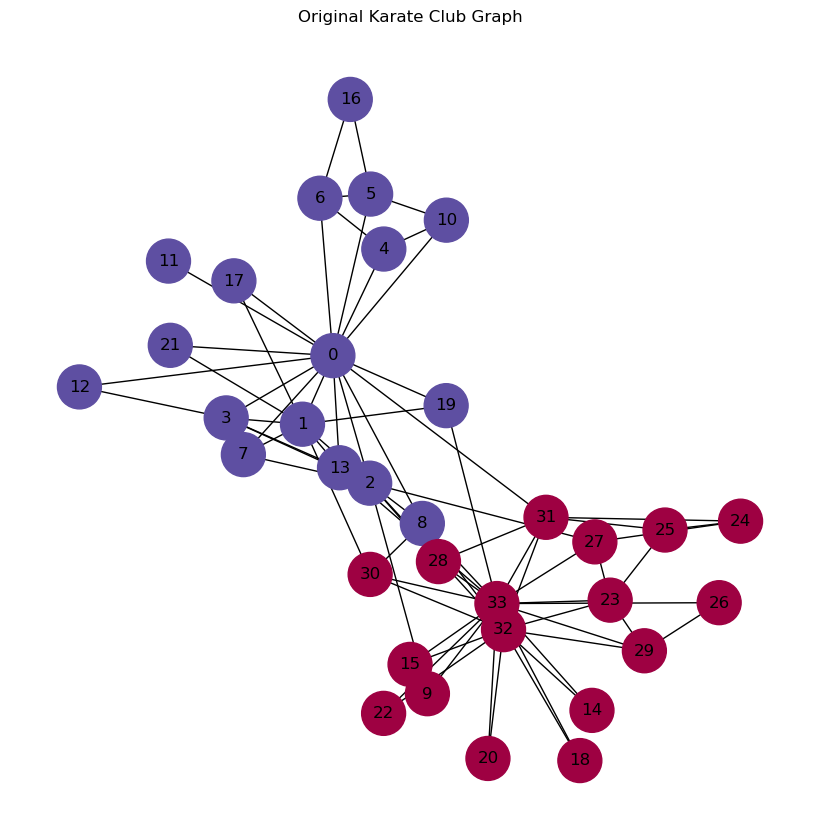

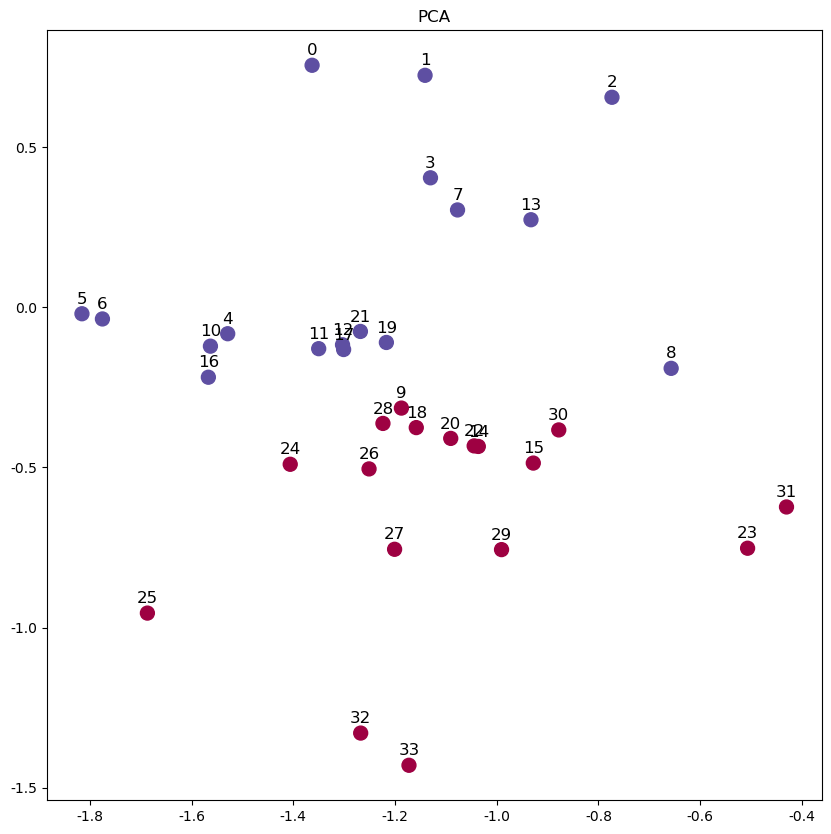

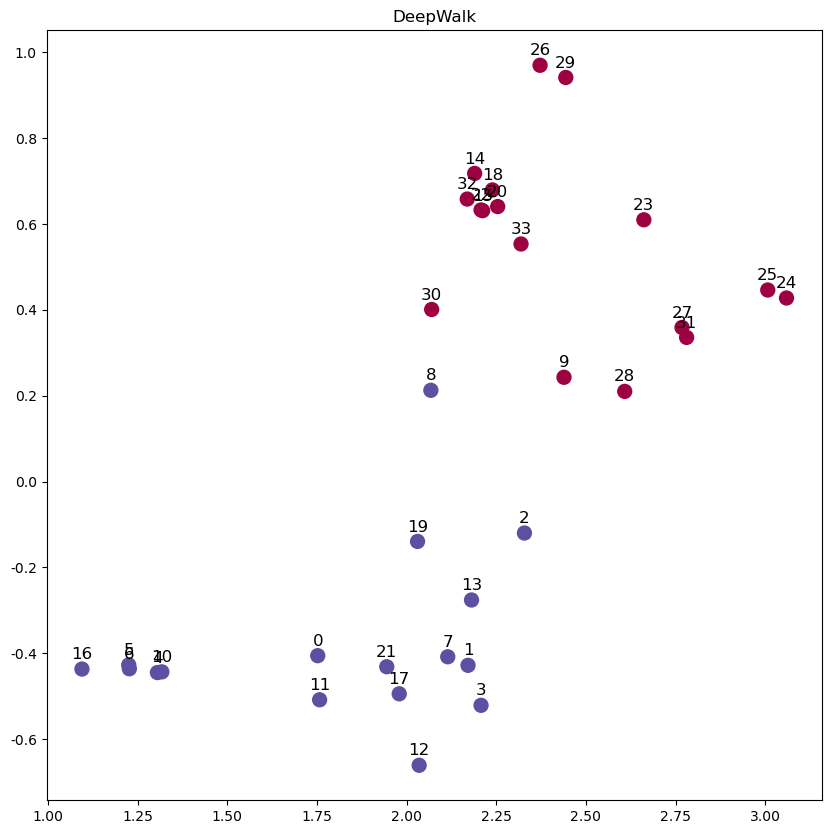

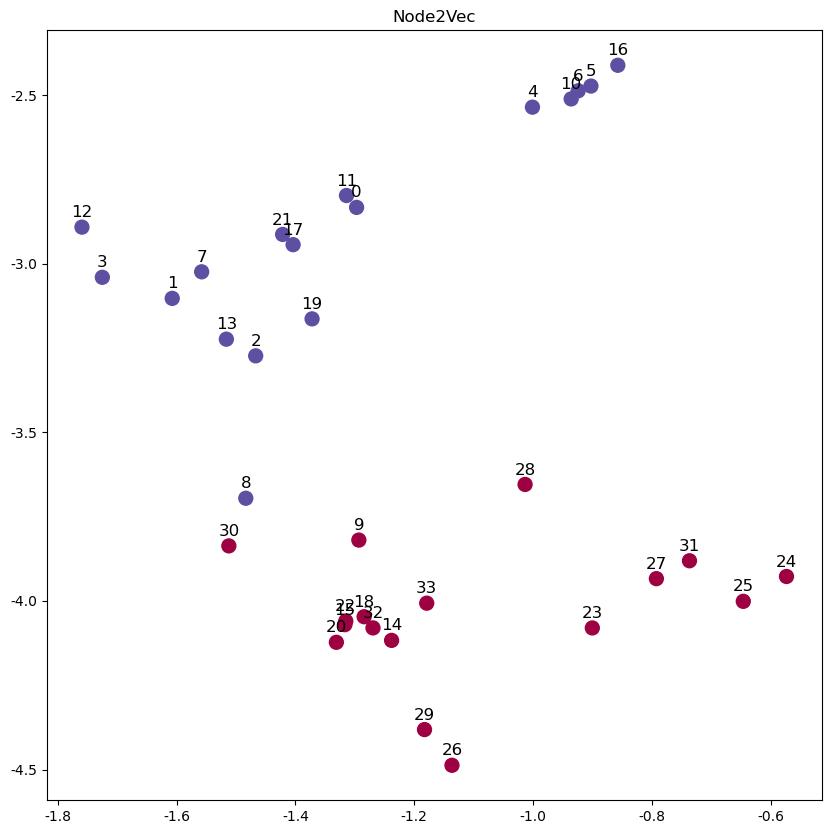

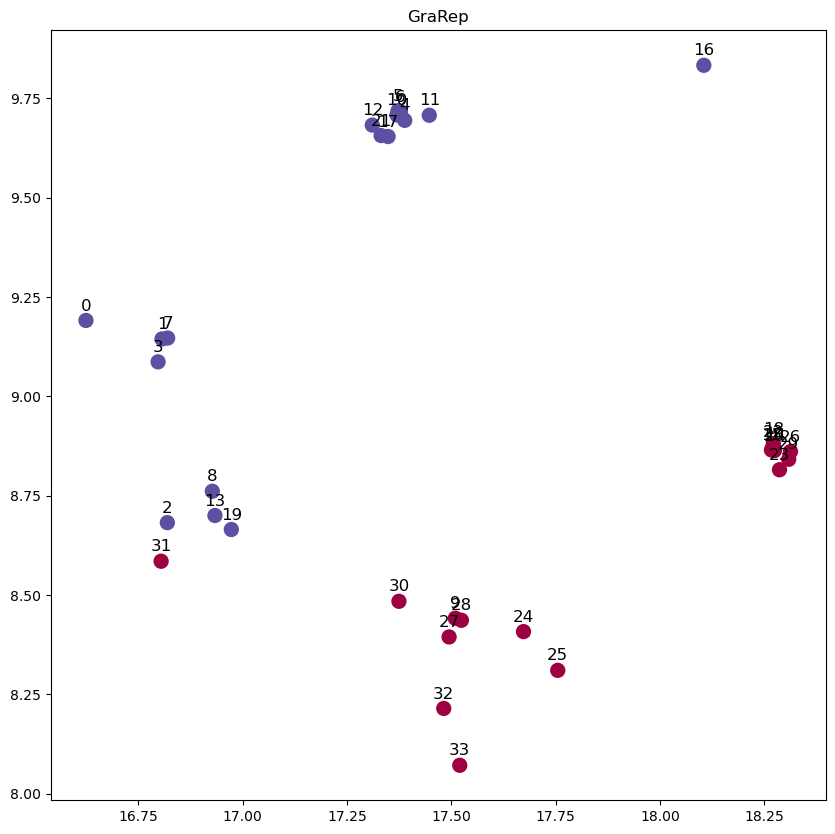

In [44]:
G = load_karate_club_data() # 加载空手道俱乐部数据
walk_length = 30 # 设置随机游走的长度
num_walks = 200 # 设置每个节点的随机游走次数
dimensions = 16 # 设置嵌入向量的维度
k_step = 4 # 设置GraRep算法中的k_step参数
unique_clubs = list(set(G.nodes[node]['club'] for node in G.nodes)) # 获取唯一的俱乐部名列表
labels = [unique_clubs.index(G.nodes[node]['club']) for node in G.nodes] # 获取节点的俱乐部标签

# 定义可视化原始空手道俱乐部图的函数
def visualize_original_graph(G, title="Original Karate Club Graph"):
    pos = nx.spring_layout(G, seed=42) # 计算节点的布局位置
    plt.figure(figsize=(8, 8))
    plt.rc('axes', unicode_minus=False)
    # 绘制图形，节点颜色表示所属俱乐部
    nx.draw(G, pos, node_color=[unique_clubs.index(G.nodes[node]['club']) for node in G.nodes], cmap='Spectral', with_labels=True, node_size=1000)
    plt.title(title)
    plt.show()

visualize_original_graph(G) # 可视化原始空手道俱乐部图

node_ids = [str(node) for node in G.nodes] # 获取节点ID的字符串形式列表

# PCA 嵌入
pca_embeds = pca_embedding(G, dimensions)
pca_embeddings_array = [pca_embeds[str(node)] for node in G.nodes]
visualize_embeddings(pca_embeddings_array, labels, node_ids, 'PCA')

# DeepWalk
deepwalk_walks = generate_walks(G, num_walks, walk_length, deepwalk_walk) # 生成DeepWalk随机游走
deepwalk_model = train_word2vec_model(deepwalk_walks, dimensions) # 使用Word2Vec训练DeepWalk模型
deepwalk_embeddings = [deepwalk_model.wv[str(node)] for node in G.nodes] # 获取节点的DeepWalk嵌入
visualize_embeddings(deepwalk_embeddings, labels, node_ids, 'DeepWalk') # 可视化DeepWalk嵌入

# Node2Vec
node2vec_walks = generate_walks(G, num_walks, walk_length, node2vec_walk, p=0.5, q=2) # 生成Node2Vec随机游走
node2vec_model = train_word2vec_model(node2vec_walks, dimensions) # 使用Word2Vec训练Node2Vec模型
node2vec_embeddings = [node2vec_model.wv[str(node)] for node in G.nodes] # 获取节点的Node2Vec嵌入
visualize_embeddings(node2vec_embeddings, labels, node_ids, 'Node2Vec') # 可视化Node2Vec嵌入

# GraRep
gra_rep_embeds = gra_rep_embedding(G, dimensions, k_step) # 计算GraRep嵌入
gra_rep_embeddings_stacked = np.vstack([gra_rep_embeds[str(node)] for node in G.nodes]) # 将GraRep嵌入堆叠为矩阵
visualize_embeddings(gra_rep_embeddings_stacked, labels, node_ids, 'GraRep') # 可视化GraRep嵌入


## 1 networkx基础练习（4分）
### 1.1 创建Graph
请按照给出的例子创建一个无向图，并绘制带节点标签的图片（1分）

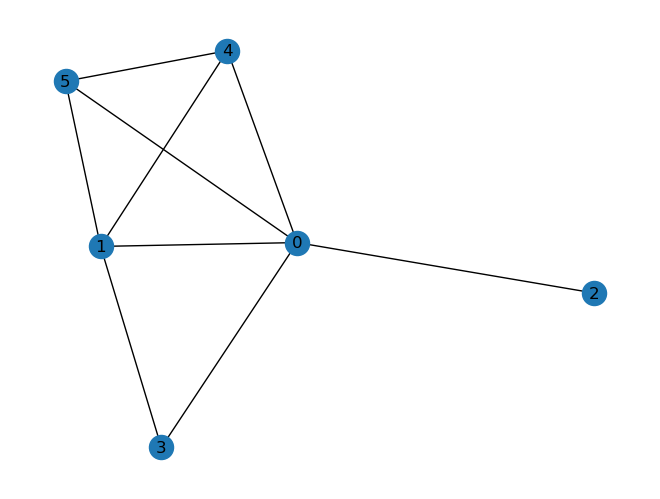

In [45]:
import networkx as nx
#TODO:
G=nx.Graph()
edge_list=[(0,1),(0,2),(0,3),(0,4),(0,5),(1,3),(1,4),(1,5),(4,5)]
G.add_edges_from(edge_list)
options={'with_labels':True}
nx.draw(G,**options)


### 1.2 修改Graph
对上面的无向图进行修改，添加6号节点，添加边（1，6），并绘制带标签的图片（1分）

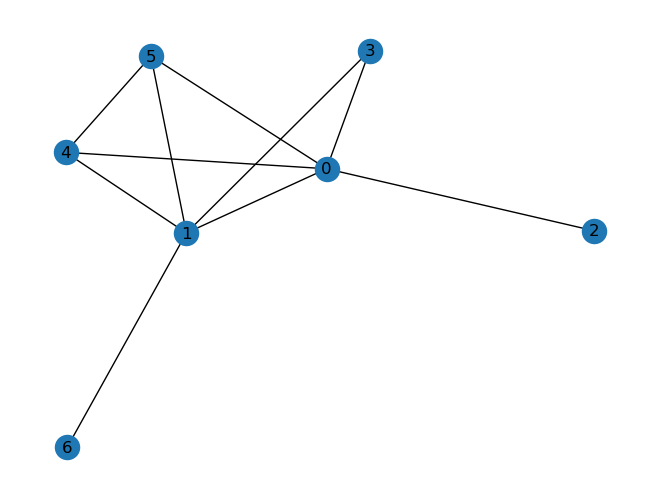

In [46]:
#TODO:
G.add_edge(1,6)
nx.draw(G,**options)

### 1.3 添加节点属性
对每一个节点添加weight属性，其值为节点的度数，并绘制带标签的图片，要求节点的大小和weight的大小成正比（1分）

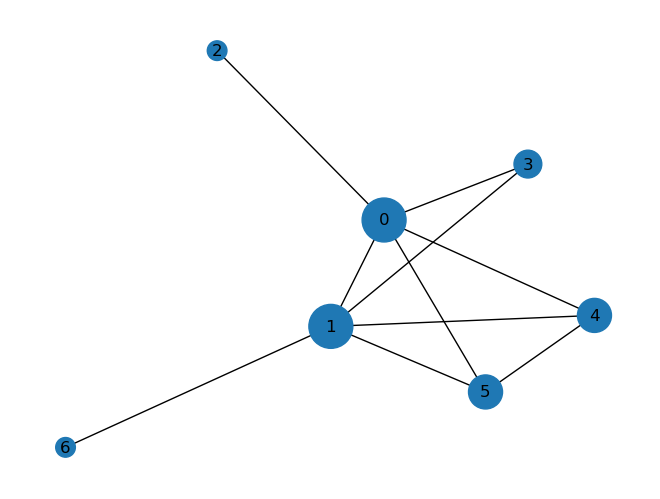

In [47]:
#TODO:
degrees=dict(G.degree())
nx.set_node_attributes(G,name='weight',values=degrees)
node_size=[v*200 for v in degrees.values()]
options={'with_labels':True,'node_size':node_size}
nx.draw(G,**options)


### 1.4 点中心度计算
计算每个节点的点中心度，并将其作为centrality属性添加到节点属性中，并按照示例输出打印节点的信息（1分）

In [48]:
#TODO:
centrality=nx.degree_centrality(G)
nx.set_node_attributes(G,name='centrality',values=centrality)
for node in G.nodes():
    print(f"Node: {node} Attributes: {G.nodes[node]}")


Node: 0 Attributes: {'weight': 5, 'centrality': 0.8333333333333333}
Node: 1 Attributes: {'weight': 5, 'centrality': 0.8333333333333333}
Node: 2 Attributes: {'weight': 1, 'centrality': 0.16666666666666666}
Node: 3 Attributes: {'weight': 2, 'centrality': 0.3333333333333333}
Node: 4 Attributes: {'weight': 3, 'centrality': 0.5}
Node: 5 Attributes: {'weight': 3, 'centrality': 0.5}
Node: 6 Attributes: {'weight': 1, 'centrality': 0.16666666666666666}


## 2 边预测（6分）
边预测（Link Prediction）是图分析中一个非常重要的任务。通常来说，边预测被处理为一个二分类任务，即对于一个图中没有边的两个节点u，v，预测其是否有边。
具体来说，对于（u，v），我们希望计算一个分数来说明其有多大可能被预测为有边，反之则是没有边。

下面我们使用空手道俱乐部的图为例子，在给定的框架下完成一个边预测的任务，并评价不同算法的性能。

Number of nodes : 34
Number of edges : 78


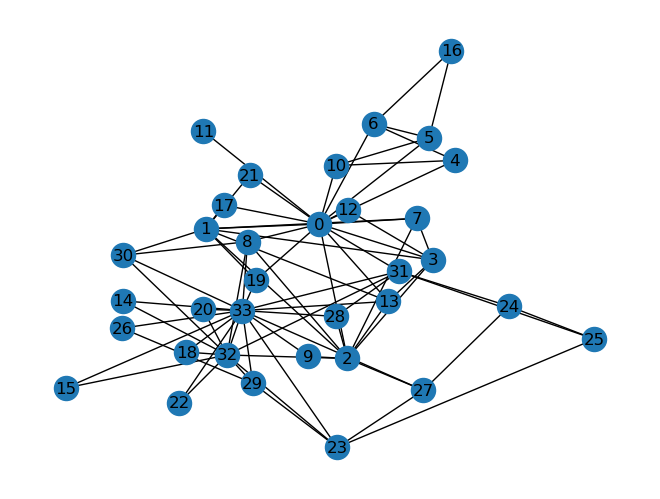

In [49]:
G_karate = nx.karate_club_graph()
print("Number of nodes : %d" % G_karate.number_of_nodes())
print("Number of edges : %d" % G_karate.number_of_edges())
nx.draw(G_karate, with_labels=True, pos=nx.kamada_kawai_layout(G_karate))

### 2.1 创建训练集
随机选择一些边进行删除（即edge_subset）中的边，复制原来的图，并在复制的图中删除这些边，作为训练集。（1分）

Number of nodes : 34
Number of edges : 59


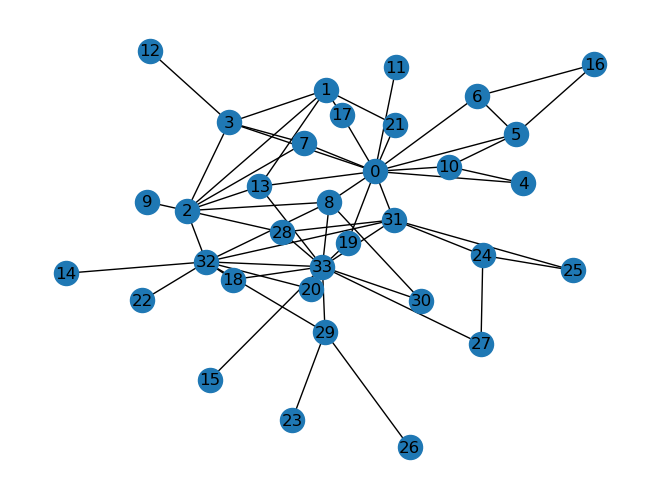

In [50]:
edge_subset = [(23, 32), (3, 13), (26, 33), (9, 33), (1, 7), 
               (15, 32), (0, 2), (14, 33), (23, 33), (4, 6), 
               (23, 27), (2, 27), (0, 1), (30, 32), (22, 33), 
               (1, 30), (0, 12), (1, 19), (23, 25)]
#TODO:
G_karate_train=G_karate.copy()
G_karate_train.remove_edges_from(edge_subset)
print("Number of nodes : %d" % G_karate_train.number_of_nodes())
print("Number of edges : %d" % G_karate_train.number_of_edges())
nx.draw(G_karate_train, with_labels=True, pos=nx.kamada_kawai_layout(G_karate_train))

### 2.2 计算分数
接下来我们将对每个没有边的节点对计算分数，首先要完善分数的计算函数，此处我们选择使用以下四种分数：
- common_neighbors
  
  $score(u,v)=|N(u)\cap N(v)|, N(u)$ is the neighbors of u.

- jaccard_coefficient
  
  $score(u,v)=\frac{|N(u)\cap N(v)|}{|N(u)\cup N(v)|}$
- adamic_adar_index
  
  $score(u,v)=\sum_{k\in N(u)\cap N(v)}\frac{1}{\log |N(k)|}$
- preferential_attachment

  $score(u,v)=|N(u)|\times|N(v)|$
  
请完善每种分数的计算函数，u，v为两个节点，G为给出的图（4分）

In [51]:
from sklearn.metrics import roc_auc_score
import math

def common_neighbors(u, v, G):
    #TODO:
    Nu=set(nx.neighbors(G,u))
    Nv=set(nx.neighbors(G,v))
    
    return len(Nu&Nv)
    

def jaccard_coefficient(u, v, G):
    #TODO:
    Nu=set(nx.neighbors(G,u))
    Nv=set(nx.neighbors(G,v))
    return len(Nu&Nv)/len(Nu|Nv)
    

def adamic_adar_index(u, v, G):
    #TODO:
    Nu=set(nx.neighbors(G,u))
    Nv=set(nx.neighbors(G,v))
    Nuv=Nu&Nv
    score=0
    for k in Nuv:
        score+=1/(math.log(len(set(nx.neighbors(G,k)))))
    return score


def preferential_attachment(u, v, G):
    #TODO:
    Nu=set(nx.neighbors(G,u))
    Nv=set(nx.neighbors(G,v))
    return len(Nu)*len(Nv)
    
print("Common Neighbors: %.4f" % common_neighbors(1, 2, G_karate_train))
print("Jaccard Coefficient: %.4f" % jaccard_coefficient(1, 2, G_karate_train))
print("Adamic Adar Index: %.4f" % adamic_adar_index(1, 2, G_karate_train))
print("Preferential Attachment: %.4f" % preferential_attachment(1, 2, G_karate_train))

Common Neighbors: 2.0000
Jaccard Coefficient: 0.1818
Adamic Adar Index: 1.3427
Preferential Attachment: 40.0000


### 2.3 预测并测评
完善下面的预测函数，对于每一对没有边的节点进行预测，将预测的值以(u,v,score)三元组的形式加入到predict中，并对预测的结果进行评测，对于此问题采用AUC作为指标（1分）

关于AUC:对于一个二分类问题，预测的结果可能出现以下四种情况：
- TP(True Positive):预测有边，实际也有边
- FP(False Positive):预测有边，实际无边
- TN(True Negative):预测无边，实际也无边
- FN(False Negative):预测无边，实际有边

ROC曲线横坐标为FPR，纵坐标为TPR，FPR=FP/(FP+TN)，TPR=TP/(TP+FN)，而AUC便是指ROC曲线下方的面积，约接近于1说明预测结果越好

In [52]:
def predict_and_evaluate(f, G):
    predict = []
    for u in G.nodes():
        for v in G.nodes():
            if u >= v or G.has_edge(u, v):
                continue
            score = f(u, v, G)
            predict.append((u, v, score))
    score, label = zip(*[(s, (u,v) in edge_subset) for (u,v,s) in predict])
    auc = roc_auc_score(label, score)
    return auc

auc_j = predict_and_evaluate(jaccard_coefficient,G_karate_train)
auc_c = predict_and_evaluate(common_neighbors,G_karate_train)
auc_a = predict_and_evaluate(adamic_adar_index,G_karate_train)
auc_p = predict_and_evaluate(preferential_attachment,G_karate_train)

print(auc_j,auc_c,auc_a,auc_p)

0.6139261196469433 0.6848098507137408 0.7179906287457773 0.7263266862809197


## 3 附加题-节点分类后处理（3分）
节点分类是图分析中一个非常重要的任务，由于课程并未在node embedding上深入，此题并不要求进行一次完整的节点分类练习，而是在一个简单的例子上模仿对于基础分类结果进行优化的过程，即进行Correct&Smooth，关于图节点分类的更多知识，请参考[链接](http://snap.stanford.edu/class/cs224w-2021/slides/05-message.pdf)

下图是一个简单的二分类图，true_labels是该图真实的标签，labels是当前已知的标签，其中未知的标签用2代替，即图中的灰色节点

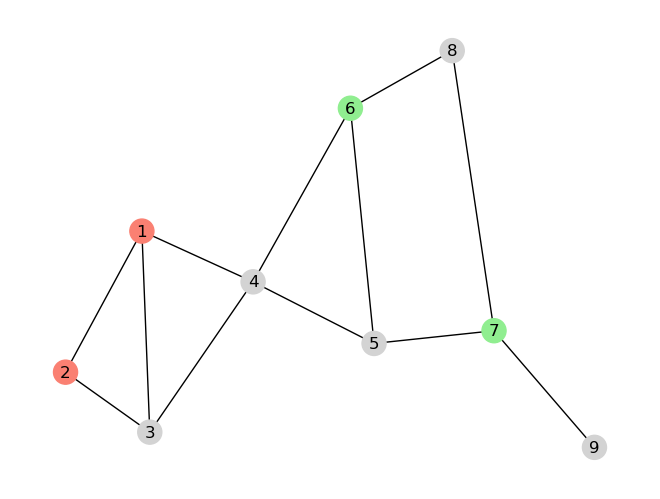

In [53]:
import numpy as np
G = nx.Graph([(1,2),(1,3),(1,4),(2,3),(3,4),(4,5),(4,6),(5,6),(5,7),(6,8),(7,8),(7,9)])
true_labels = np.array([1,1,1,1,0,0,0,0,0])
labels = np.array([1,1,2,2,2,0,0,2,2])
color = ['lightgreen','salmon','lightgray']
nx.draw(G,with_labels=True,pos=nx.spring_layout(G),node_color=[color[label] for label in labels])

经过一个基础的节点分类模型，我们得到了一个soft_labels，其每一个元素是一个二元组(p,q)，p是预测类别为0的概率，q是预测类别为1的概率，我们将它转换为预测的标签，可以观察到基础模型在一个简单的问题上也与真实标签存在出入

In [54]:
soft_labels = np.array([(0.05,0.95),(0.3,0.7),(0.6,0.4),(0.2,0.8),(0.9,0.1),(0.6,0.4),(0.95,0.05),(0.4,0.6),(0.8,0.2)])
pred_labels = soft_labels.argmax(axis=1)
print(pred_labels)
print(true_labels)

[1 1 0 1 0 0 0 1 0]
[1 1 1 1 0 0 0 0 0]


### 3.1 标准化混淆矩阵
为了实现Correct&Smooth，我们需要定义标准化混淆矩阵，其定义如下：

$\hat{A}=D^{-1/2}AD^{-1/2}$
其中$A$是对角线全为1的邻接矩阵，$D=diag(d_1,d_2,\cdots),d_i$是节点的度数，请计算题目中给出图的标准化混淆矩阵（1分）

In [55]:
#TODO:
degrees=dict(G.degree())
D=np.diag([v for v in degrees.values()])
A=nx.to_numpy_array(G)+np.eye(G.number_of_nodes())
D_=np.linalg.inv(np.sqrt(D))
A_=D_@A@D_
A_



array([[0.33333333, 0.40824829, 0.33333333, 0.28867513, 0.        ,
        0.        , 0.        , 0.        , 0.        ],
       [0.40824829, 0.5       , 0.40824829, 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        ],
       [0.33333333, 0.40824829, 0.33333333, 0.28867513, 0.        ,
        0.        , 0.        , 0.        , 0.        ],
       [0.28867513, 0.        , 0.28867513, 0.25      , 0.28867513,
        0.28867513, 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.28867513, 0.33333333,
        0.33333333, 0.33333333, 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.28867513, 0.33333333,
        0.33333333, 0.        , 0.40824829, 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.33333333,
        0.        , 0.33333333, 0.40824829, 0.57735027],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.40824829, 0.40824829, 0.5       , 0.        ],


### 3.2 Correct Step
Correct Step期望模型的预测误差是沿着边正相关的，即邻居节点的误差相似，为了完成该步骤，我们需要创建一个矩阵E，其shape为(num_of_nodes,2)。对于待预测的节点，节点对应行的值为(0,0)，对于已知真实标签的节点，节点对应行的值为true_label-soft_label，例如题中的节点1，该行对应的值为(0,1)-(0.05,0.95)=(-0.05,0.05)（0.5分）

In [56]:
#TODO:
E=np.zeros((G.number_of_nodes(),2))
for i in range(labels.size):
    if labels[i]==2:
        continue
    if true_labels[i]==0:
        E[i][0]=1-soft_labels[i][0]
        E[i][1]=0-soft_labels[i][1]
    else:
        E[i][0]=0-soft_labels[i][0]
        E[i][1]=1-soft_labels[i][1]
E


array([[-0.05,  0.05],
       [-0.3 ,  0.3 ],
       [ 0.  ,  0.  ],
       [ 0.  ,  0.  ],
       [ 0.  ,  0.  ],
       [ 0.4 , -0.4 ],
       [ 0.05, -0.05],
       [ 0.  ,  0.  ],
       [ 0.  ,  0.  ]])

对于得到的矩阵E，按照如下公式进行迭代更新：
$E^{(t+1)}=(1-\alpha)E^{(t)}+\alpha\hat{A}E^{(t)}$，我们设定$\alpha=0.8$，迭代轮数为3，并将迭代更新后的矩阵加到soft_labels上得到新的soft_labels（0.5分）

In [57]:
alpha = 0.8
for i in range(3):
    #TODO:
    E=(1-alpha)*E+alpha*A_@E
soft_labels=soft_labels+E
soft_labels

array([[-0.09795431,  1.09795431],
       [ 0.09833014,  0.90166986],
       [ 0.45244569,  0.54755431],
       [ 0.23246086,  0.76753914],
       [ 1.04901551, -0.04901551],
       [ 0.78415625,  0.21584375],
       [ 1.09908148, -0.09908148],
       [ 0.58790308,  0.41209692],
       [ 0.88077772,  0.11922228]])

### 3.3 Smooth Step
Smooth Step期望相邻的节点拥有同样的标签，为了完成该步骤，我们需要创建一个矩阵Z，其shape为(num_of_nodes,2)。对于待预测的节点，节点对应行的值为它的soft_label，对于已知真实标签的节点，节点对应行的值为true_label，例如题中的节点1，该行对应的值为(0,1)（0.5分）

    注:直接在soft_labels中替换掉已知真实标签的节点对应的值

In [58]:
#TODO:
Z=np.zeros((G.number_of_nodes(),2))
for i in range(labels.size):
    if labels[i]==2:
        Z[i]=soft_labels[i]
        continue
    Z[i][0]=1-true_labels[i]
    Z[i][1]=true_labels[i]
Z

array([[ 0.        ,  1.        ],
       [ 0.        ,  1.        ],
       [ 0.45244569,  0.54755431],
       [ 0.23246086,  0.76753914],
       [ 1.04901551, -0.04901551],
       [ 1.        ,  0.        ],
       [ 1.        ,  0.        ],
       [ 0.58790308,  0.41209692],
       [ 0.88077772,  0.11922228]])

将Z按照E的方式进行迭代，迭代轮数为3，迭代更新后的矩阵就是新的soft_labels（0.5分）

In [59]:
alpha = 0.8
for i in range(3):
    #TODO:
    Z=(1-alpha)*Z+alpha*A_@Z
soft_labels=Z
soft_labels

array([[0.53675471, 1.59721729],
       [0.37713077, 1.66531633],
       [0.54037428, 1.59359773],
       [1.08776865, 1.11948537],
       [1.61917457, 0.54101631],
       [1.55925187, 0.58351043],
       [2.56470229, 0.40618231],
       [1.83164192, 0.40149847],
       [2.82472359, 0.3205936 ]])

观察后处理之后的预测结果，与真实的标签一致

In [60]:
pred_labels = soft_labels.argmax(axis=1)
print(pred_labels)
print(true_labels)

[1 1 1 1 0 0 0 0 0]
[1 1 1 1 0 0 0 0 0]
